## Purpose

This notebook uses the Siamese network to classify coffee diseases. The siamese model is used to build a set of image embeddings such that intra-class images are close to each other in the embedding space, whereas the inter-class images are further apart from each other.
We use a distance metric like the euclidean distance, dot-product etc to get the similarity measure.

The distance measure will then be used to classify the test images into their predicted disease classes.

The advantage of using this method is 2-fold:
1. We can use a simple K-nearest neighbor approach to classify the test image.
2. The setup can more visually explain why the model chose the particular class.

In [33]:
!python -c "import ipyplot" || pip install -qU "ipyplot"
!python -c "import imutils" || pip install -qU "imutils"

## Setup the Google Colab

In [34]:
import os
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import ipyplot

If using Google Drive please mount it. Only works in Colab.

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

Set some environment variables for the data location. This is just for convenience

In [36]:
%env DATA_DIRECTORY = /home/ubuntu/Downloads
%env TEST_DATA_DIRECTORY = /home/ubuntu/Downloads

env: DATA_DIRECTORY=/home/ubuntu/Downloads
env: TEST_DATA_DIRECTORY=/home/ubuntu/Downloads


In [37]:
# %env DATA_DIRECTORY = C:\Workspace\Practice\Python\LeraningWorkspace\data
# %env TEST_DATA_DIRECTORY = C:\Workspace\Practice\Python\LeraningWorkspace\data

In [38]:
# %env DATA_DIRECTORY = /content/drive/MyDrive/Task-3-Data Augmentation/data
# %env TEST_DATA_DIRECTORY = /content/drive/MyDrive/Task-4-Model(s) Building/data

Set the root directory where the data is located.

In [39]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/ubuntu/Downloads


## Utility functions.

Add convenience functions here

In [40]:
## Code to clean kaggle output folders
def remove_folder_contents(folder, recurse=False):
    """
        Given an input folder, remove all its contents. The folder itself is not
        deleted
        @input - folder name
        @recurse - recursive delete Yes or No
    """
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                if recurse is True:
                    remove_folder_contents(file_path)
                    os.rmdir(file_path)
                continue
        except Exception as e:
            print(e)

In [41]:
def checkPathExists(path):
  """
  Given an input path, confirm if the path exists.
  @input - a directory path
  """
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [42]:
def buildCropDiseaseCountTuple(instanceFolder):
    """
    Given a class folder, find the number of samples of that class and return
    a tuple of the form ('Crop Name', 'Class Name', 'Count')
    Note: Name of Crop and Disease is the folder name so split it .
          Need to change the logic here based on the data source . Much Pain!!
    @input - Class Folder
    @return - Tuple ('Crop Name', 'Class Name', 'Count')
    """
    str_name = str(instanceFolder.name)
    str_name = str_name.replace(" leaf", "").rstrip()
    print(str_name)
    values = str_name.split(" ", 2)
    f = instanceFolder.rglob('*')
    counts = np.unique([x.parent for x in f], return_counts=True)[1]
    if len(values) == 1:
        values = ['Coffee', values[0]]
        #values.append('healthy')
    return (values[0], values[1], counts[0].tolist())

In [43]:
def readFolderAndSaveDataFrame(DataFolder, classNames=None):
    '''
    Read the folder - Note the assumption here is that the images are already seperated into their respective class subfolders
    Example -
        <root>
            - <class 1>
                - <image 1>
                - <image 2>
            - <class 2>
                - <image 1>
                - <image 2>
    '''
    dataFolder = Path(f"{DataFolder}")
    dataList = []
    # Get all the folders within the path - The list of folders are the classes.
    if classNames != None:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir() and f.name in classNames]
    else:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir()]
    for classPath in instancePathList:
        dataList.append(buildCropDiseaseCountTuple(classPath))

    ## Make a DataFrame
    samplesDataFrame = pd.DataFrame(dataList, columns=['Crop', 'Disease', 'numberImages'])
    return samplesDataFrame

In [44]:
def generate_pie_plot(df, title="Categories", ax = None):
    """
    Generate a pie plot showing the proportion of the different classes
    of the target variable
    @input - A pandas data frame
    @input - Title of the plot
    @input - Axes object from matplotlib
    """
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        #print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [45]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames, outputfilename):
    """
    Build a CSV file for the dataset
    @input - Directory where the data is located
    @input - Output location for the CSV file
    @input - Classnames
    @input - Name of the CSV file
    """
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath(outputfilename))

In [46]:
def LoadData(inputDir, imageSize):
    """
    Given the dataset folder, load the CSV file, and return a tuple of
    the form (<Image_paths> <Image_class> <Image_id>)
    @input - dataset directory
    @input - image size - This is not used
    """
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            all_classes.append(df.iloc[i]['ClassName'])
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

In [47]:
def resize_image(input_folder, output_folder):
  """
  Augment all the images in the input  folder: resize images to 256 x 256
  @input - dataset folder
  @input - Output directory where resized images are stored
  """
  for c in CLASSNAMES:
    folder_path = Path(input_folder)/c
    output_path = Path(output_folder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      #print(image_path)
      img = cv2.imread(str(image_path))
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, [256, 256])
      cv2.imwrite(str(output_path/image_path.name), img)
      #print(output_path/image_path.name)
  return

In [48]:
import imutils
def rotate_image(input_folder, output_folder):
  """
  Augment all the images in the input  folder: rotate images to the following
  3 rotation angles: 90, 180 and 270
  @input - dataset folder
  @input - Output directory where resized images are stored
  """
  for c in CLASSNAMES:
    folder_path = Path(input_folder)/c
    output_path = Path(output_folder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      #print(image_path)
      img = cv2.imread(str(image_path))
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      for angle in np.arange(0, 360, 90):
        rotated = imutils.rotate_bound(img, angle)
        opfile = output_path.joinpath(f"Aug_rot_{angle}_{image_path.name}")
        cv2.imwrite(str(opfile), rotated)
        #break

  return

In [49]:
import ipyplot
def VisualizeAsClassTabs(csvFile, classNames, size):
  """
  This is a simple UI to have representative images from multiple classes,
  visualized within its own class tab.
  @input - CSV file for the dataset
  @input - ClassNames used for the tabs
  @input - number of images per class to visualize
  """
  df = pd.read_csv(csvFile)
  inputDir = csvFile.parent
  image_array = []
  label_array = []
  for c in CLASSNAMES:
    cdf = df.query(f'ClassName == "{c}"')
    for i in np.random.choice(np.arange(0, cdf.shape[0]), size=(size,)):
      file = cdf.iloc[i]['FileName']
      img = cv2.imread(str(inputDir.joinpath(file)))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      label_array.append(cdf.iloc[i]['ClassName'])
      image_array.append(img)

  ipyplot.plot_class_tabs(image_array, label_array, max_imgs_per_tab = size, img_width=150)


In [50]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

## Get the original coffee dataset

Set the train and test directory location.

In [51]:
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']

In [52]:
SINGLE_LEAVES_DATA_DIR_TRAIN = Path(root_dir).joinpath('train_opencv_resized')
testDirectory = os.environ.get("TEST_DATA_DIRECTORY")
SINGLE_LEAVES_DATA_DIR_TEST = Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized')
checkPathExists(SINGLE_LEAVES_DATA_DIR_TEST)
checkPathExists(SINGLE_LEAVES_DATA_DIR_TRAIN)

Path /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized accessible
Path /home/ubuntu/Downloads/train_opencv_resized accessible


### Only run the first time. Make the CSVs to load the image data conveniently

If you want to augment the data before training, uncomment the lines below

In [53]:
#Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized_rot').mkdir(parents=True, exist_ok=True)
#rotate_image(SINGLE_LEAVES_DATA_DIR_TRAIN, Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized_rot'))

If you want to resize the images to the same size, uncomment the lines below.

In [54]:
#resize_image(SINGLE_LEAVES_DATA_DIR_TEST, Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized'))

Read the training and the testing data and build a pandas dataframe which lists the number of samples for each class. This is only used for visualization purposes only.

Phoma
Rust
Cescospora
Miner
Healthy
Phoma
Rust
Cescospora
Miner
Healthy
------------------
Number of images in Training Folder
     Crop     Disease  numberImages
0  Coffee       Phoma           826
1  Coffee        Rust          1671
2  Coffee  Cescospora           200
3  Coffee       Miner          1009
4  Coffee     Healthy           738
------------------
Number of images in Testing Folder
     Crop     Disease  numberImages
0  Coffee       Phoma           107
1  Coffee        Rust           921
2  Coffee  Cescospora           112
3  Coffee       Miner           369
4  Coffee     Healthy           791


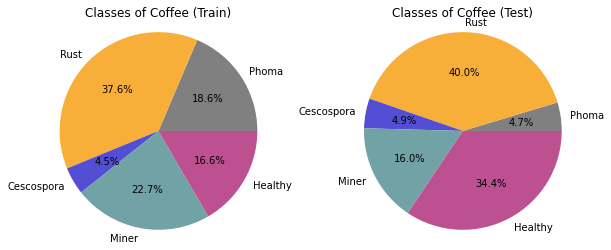

In [55]:
coffeedatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES)
coffeetestdatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES)
print("------------------")
print("Number of images in Training Folder")
print(coffeedatadf.head())
print("------------------")
print("Number of images in Testing Folder")
print(coffeetestdatadf.head())
fig, ax = plt.subplots(1, 2, figsize=(10,4))
generate_pie_plot(coffeedatadf, 'Classes of Coffee (Train)', ax[0])
generate_pie_plot(coffeetestdatadf, 'Classes of Coffee (Test)', ax[1])

Building a CSV metafile of image info that I will use to load the data later.
Make this only if the original dataset does not have a csv meta file. Only need to build this the first time.

In [56]:
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TRAIN, SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES, 'coffeediseasedata.csv')
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TEST, SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES, 'coffeediseasetestdata.csv')

Tracking /home/ubuntu/Downloads/train_opencv_resized/Phoma
Tracking /home/ubuntu/Downloads/train_opencv_resized/Rust
Tracking /home/ubuntu/Downloads/train_opencv_resized/Cescospora
Tracking /home/ubuntu/Downloads/train_opencv_resized/Miner
Tracking /home/ubuntu/Downloads/train_opencv_resized/Healthy
4444
(4444, 5)
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Phoma
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Rust
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Cescospora
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Miner
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Healthy
2300
(2300, 5)


## Load the Coffee Data for Training

These are config variables. List all of them here

In [57]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR_TRAIN / 'coffeediseasedata.csv'
batch_size = 16

Build an array of images and classes

In [58]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TRAIN, IMAGE_SIZE)
coffee_test_images, coffee_test_classes, coffee_test_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TEST, IMAGE_SIZE)

4444
2300


Split test data into validation and testing images

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
alt_images, alt_test_images, alt_id, alt_test_id, alt_class, alt_test_class = \
train_test_split(coffee_test_images, coffee_test_ids, coffee_test_classes,
                 test_size=0.8, random_state=1234, shuffle=True, stratify=coffee_test_classes)

val_images, test_images, val_id, test_id, val_class, test_class = \
train_test_split(alt_test_images, alt_test_id, alt_test_class,
                 test_size=0.5, random_state=1234, shuffle=True, stratify=alt_test_class)

In [61]:
#val_images, test_images, val_id, test_id, val_class, test_class = \
#train_test_split(coffee_test_images, coffee_test_ids, coffee_test_classes,
#                 test_size=0.5, random_state=1234, shuffle=True, stratify=coffee_test_classes)

Build a pandas dataframe that has the counts of training, testing and validation images. This is used only for visualiztion of the pie plot.

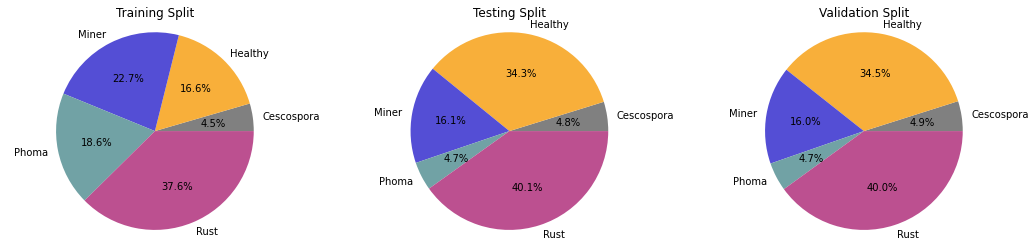

In [62]:
train_df = pd.DataFrame(np.array(np.unique(coffee_classes, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
val_df = pd.DataFrame(np.array(np.unique(val_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
test_df['numberImages'] = test_df['numberImages'].astype('int32')
val_df['numberImages'] = val_df['numberImages'].astype('int32')
fig, ax = plt.subplots(1, 3, figsize=(18,4))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(test_df, title="Testing Split", ax=ax[1])
generate_pie_plot(val_df, title="Validation Split", ax=ax[2])

Visualize some sample input images

In [63]:
def buildMontage(row, col, figSize, image_array, plot_label_array):
  plt.subplots(row, col, figsize=figSize)
  num_total = image_array.shape[0]
  for i, k in enumerate(np.random.randint(num_total, size=row*col)):
      image = cv2.imread(image_array[k])
      plt.subplot(4, 4, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image, True)
      plt.xlabel(plot_label_array[k])

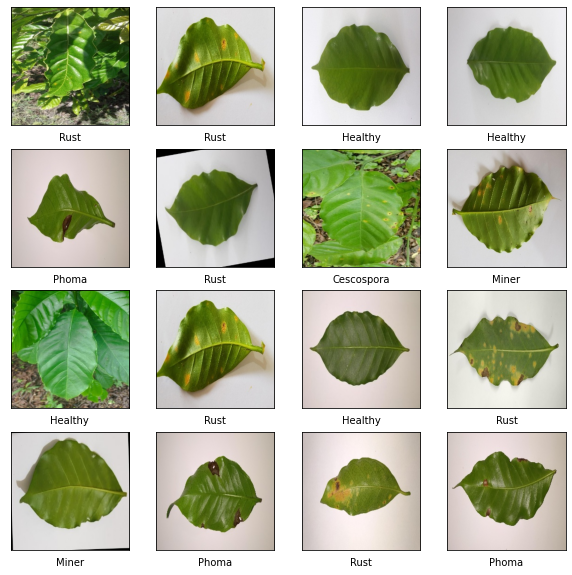

In [64]:
buildMontage(4, 4, (10,10), coffee_images, coffee_classes)

Adding an alternate mechanism to visualize images using ipyplot. This is only for demonstration. Using ipyplot to load images increases the size of notebook dramatically.


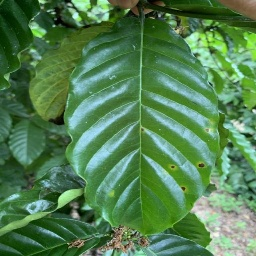
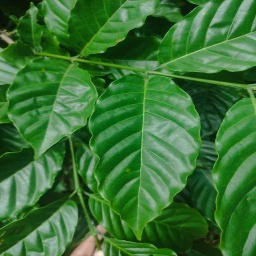
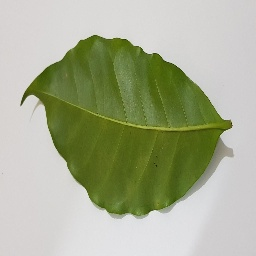
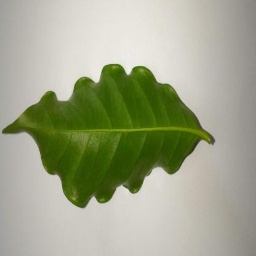
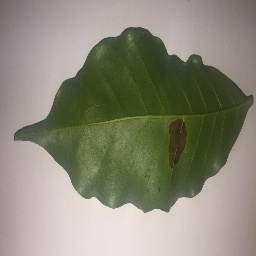
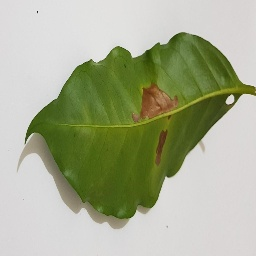
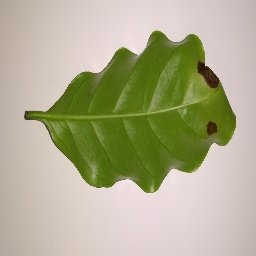
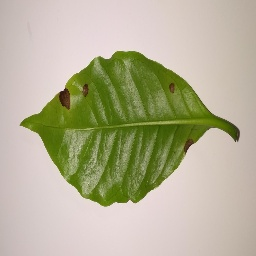
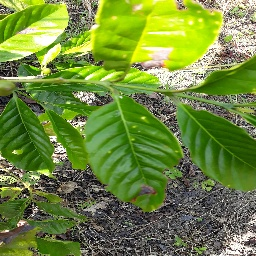
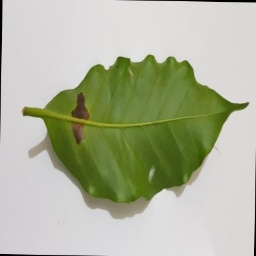


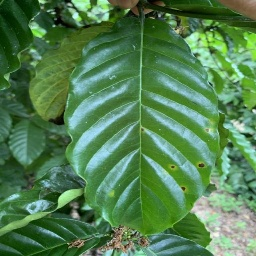
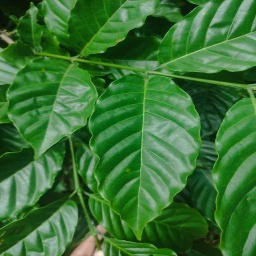
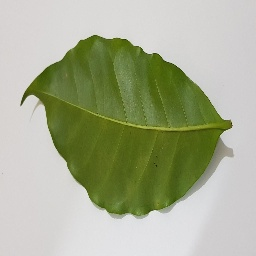
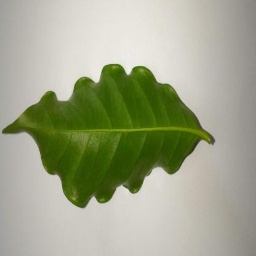
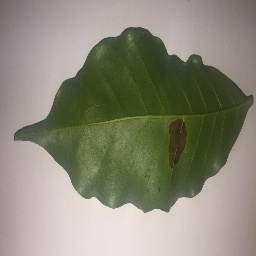
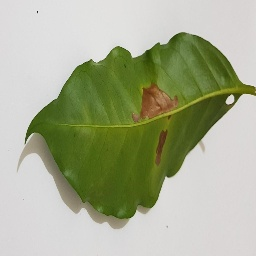
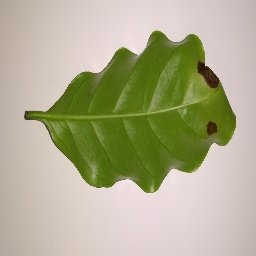
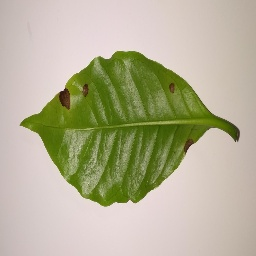
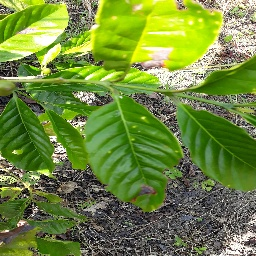
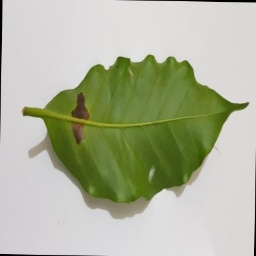

In [65]:
VisualizeAsClassTabs(META_DATA_FILE, CLASSNAMES, 2)


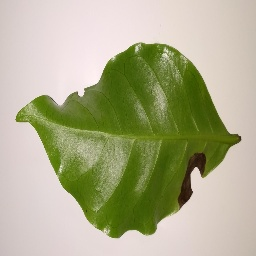
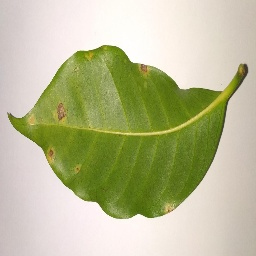
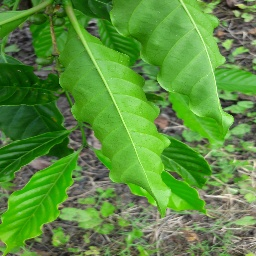
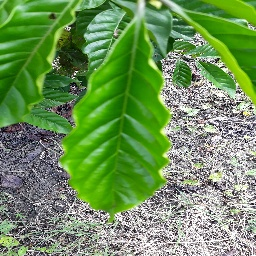
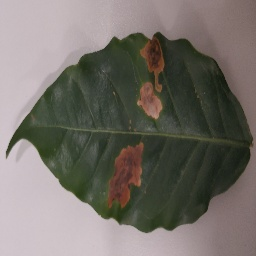
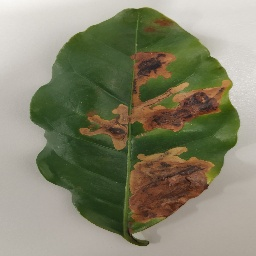
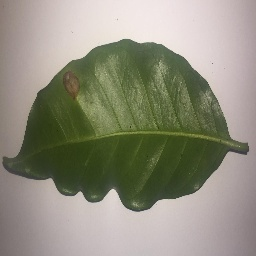
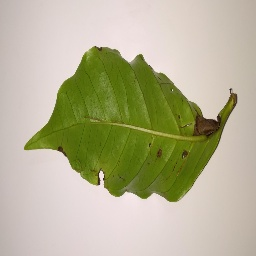
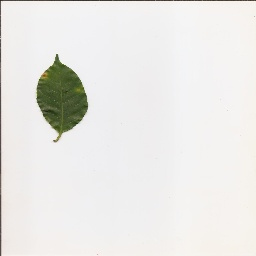
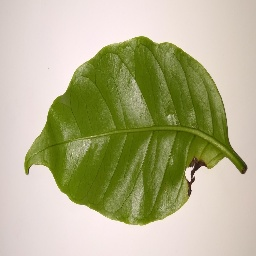


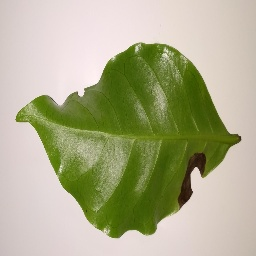
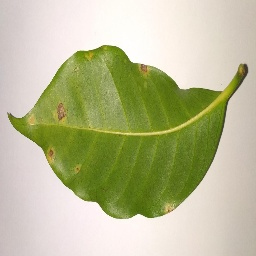
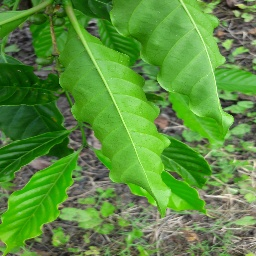
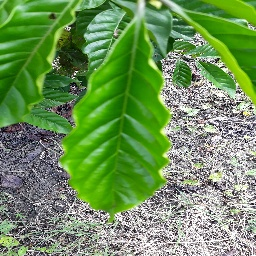
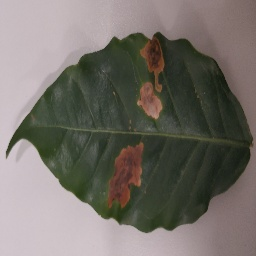
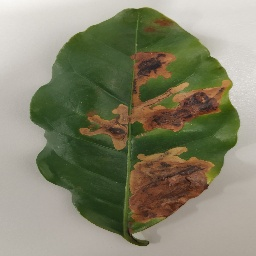
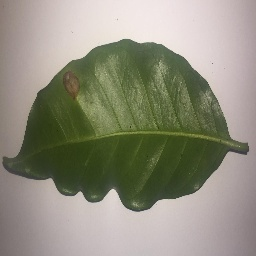
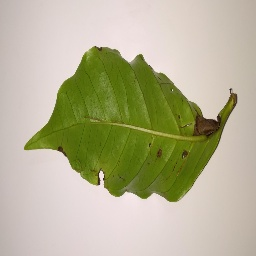
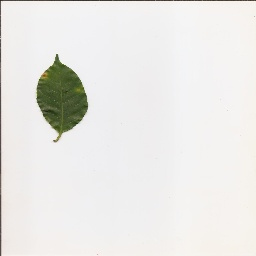
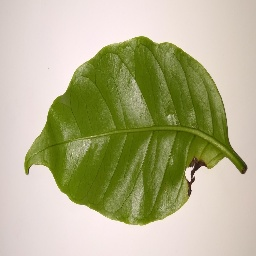

In [66]:
VisualizeAsClassTabs(SINGLE_LEAVES_DATA_DIR_TEST/'coffeediseasetestdata.csv', CLASSNAMES, 2)

### Build a Tensorflow dataset from the Coffee dataset

In [67]:
import tensorflow as tf

In [68]:
def make_pairs(images, labels):
    """
    Make pairs of images. There are the positive image pairs that are from the
    same class. It will have a label of 1. Similarly, there are negative image
    pairs the have images from different class. These pairs have a label of 1.
    The output will be a numpy array with the following elements:
    (<Image 1> <Image 2> <label>)
    @input - all the dataset image paths
    @input - class label for each of the image path
    @return - numpy array of tuples (Image, Image, label)
    """
    pairImages = []
    pairLabels = []
    pairData = []

    classes = np.unique(labels)
    idx = [np.where(labels == i)[0] for i  in classes]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        #print(f"Current: {currentImage}")

        idxB = np.random.choice(idx[list(classes).index(label)])
        posImage = images[idxB]
        #print(f"Pos Image: {posImage}")

        pairData.append((currentImage, posImage, 1))

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        #print(f"Neg Image: {negImage}")

        pairData.append((currentImage, negImage, 0))

    return np.asarray(pairData)


Build the set of training image pairs. The pairs have both images from same class and images from differnt classes.

In [69]:
coffee_images = np.concatenate((coffee_images, alt_images), axis=None)
coffee_classes = np.concatenate((coffee_classes, alt_class), axis=None)

In [70]:
coffee_classes.shape

(4904,)

In [71]:
train_pairs = make_pairs(coffee_images.tolist(), coffee_classes)

Convert the image pairs in numpy to a tf.Data

In [72]:
train_ds = tf.data.Dataset.from_tensor_slices(train_pairs)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

Do the same for the validation dataset

In [73]:
val_pairs = make_pairs(val_images.tolist(), val_class)
val_ds = tf.data.Dataset.from_tensor_slices(val_pairs)

Sample pairs

In [74]:
for f in train_ds.take(5):
  print(f.numpy())

[b'/home/ubuntu/Downloads/train_opencv_resized/Phoma/cld-kaggle-train-phoma (286).jpg'
 b'/home/ubuntu/Downloads/train_opencv_resized/Phoma/cld-kaggle-train-phoma (272).jpg'
 b'1']
[b'/home/ubuntu/Downloads/train_opencv_resized/Rust/1239.jpg'
 b'/home/ubuntu/Downloads/train_opencv_resized/Rust/cld-kaggle-train-rust (79).jpg'
 b'1']
[b'/home/ubuntu/Downloads/train_opencv_resized/Rust/cld-kaggle-train-rust (217).jpg'
 b'/home/ubuntu/Downloads/train_opencv_resized/Rust/1510.jpg' b'1']
[b'/home/ubuntu/Downloads/train_opencv_resized/Rust/1366.jpg'
 b'/home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Healthy/C3P22H1.jpg'
 b'0']
[b'/home/ubuntu/Downloads/train_opencv_resized/Phoma/cld-kaggle-train-phoma (295).jpg'
 b'/home/ubuntu/Downloads/train_opencv_resized/Phoma/cld-kaggle-train-phoma (135).jpg'
 b'1']


Check the number of pairs for both training and validation set

In [75]:
print(f"Number of image pairs in the training set: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of image pairs in the training set: {tf.data.experimental.cardinality(val_ds).numpy()}")

Number of image pairs in the training set: 9808
Number of image pairs in the training set: 1840


We will convert the training and validation data in tf.Data to a format that the Tensorflow models will accept. Below is some boilerplate code that will do the same.

In [76]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(data_bits):
  label_1 = get_label(data_bits[0])
  label_2 = get_label(data_bits[1])
  # Load the raw data from the file as a string
  img_1 = tf.io.read_file(data_bits[0])
  img_1 = decode_img(img_1)
  img_2 = tf.io.read_file(data_bits[1])
  img_2 = decode_img(img_2)
  return (img_1, img_2), int(data_bits[2])

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [77]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [78]:
def VisualizePairSamples(dataset):
  image_batch, label_batch = next(iter(dataset))
  lls = {0: "Different Class (0)", 1: "Same Class (1)"}

  for i, k in enumerate(np.random.randint(batch_size, size=8)):
      plt.subplots(1, 2, figsize=(4,2))
      plt.subplot(1, 2, 1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image_batch[0][k].numpy().astype('uint8'))
      plt.suptitle(f"{lls[label_batch[k].numpy()]}")
      plt.subplot(1, 2, 2)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image_batch[1][k].numpy().astype('uint8'))
      plt.show()

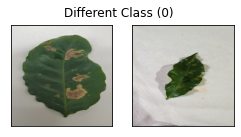

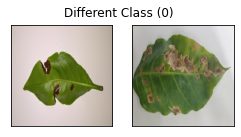

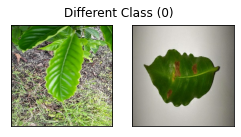

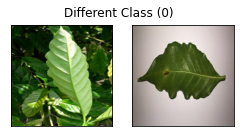

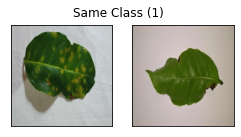

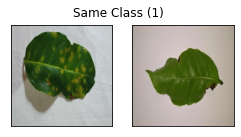

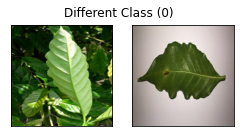

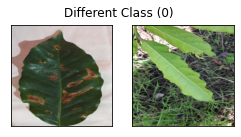

In [79]:
VisualizePairSamples(val_ds)

### Build the Coffee Disease Classification model

In [80]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization, Lambda
import tensorflow.keras.backend as K

In [81]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [82]:
def build_siamese_model(inputShape, embeddingDim=250, trainBackbone=False):
  backbone = MobileNetV2(input_shape=inputShape,
                         weights='imagenet',
                         include_top=False)
  backbone.trainable = trainBackbone

  MODEL_NAME = 'Coffee_Disease_Siamese_Model'
  #InputLayer
  inputs = Input(shape=inputShape, name="InputLayer")
  # Preprocess Input
  x = mobilenet_v2.preprocess_input(inputs)
  # MobileNetV2 Backbone
  x = backbone(x)
  # Regularization
  x = Dropout(0.3, name="DropOut")(x)
  # FCN
  x = Flatten()(x)
  x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
  x = BatchNormalization()(x)
  # Outputs
  x = Dense(embeddingDim)(x)
  outputs = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
  #Model
  model = Model(inputs, outputs, name=MODEL_NAME)
  return model

Train the Siamese Model

In [83]:
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)

    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin -preds, 0))
    loss = K.mean(y * squaredPreds + (1-y)*squaredMargin)

    return loss

def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    #plt.plot(H.history["accuracy"], label="train_acc")
    #plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.savefig(plotPath)
    plt.show()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [84]:
EPOCHS = 30
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
#batch_size = 8

In [85]:
def train_siamese_model(epochs, train_ds, val_ds):
  print("[INFO] building siamese network...")
  imgA = Input(shape=IMG_SHAPE)
  imgB = Input(shape=IMG_SHAPE)
  featureExtractor = build_siamese_model(IMG_SHAPE, 256, True)
  featsA = featureExtractor(imgA)
  featsB = featureExtractor(imgB)

  distance = Lambda(euclidean_distance)([featsA, featsB])
  model = Model(inputs=[imgA, imgB], outputs=distance)

  print("[INFO] compiling model...")
  model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-4), metrics=[accuracy])

  print("[INFO] training model...")
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      batch_size = batch_size,
      epochs = epochs
  )

  print("[INFO] saving siamese model...")
  #model.save(config.MODEL_PATH)

  print("[INFO] saving Siamese model...")
  plot_training(history, "savefig.png")

  return model

[INFO] building siamese network...
9406464/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training model...
Epoch 1/30
613/613 [==============================] - 97s 121ms/step - loss: 0.3442 - accuracy: 0.6779 - val_loss: 0.4922 - val_accuracy: 0.7359
Epoch 2/30
613/613 [==============================] - 72s 117ms/step - loss: 0.2375 - accuracy: 0.7811 - val_loss: 0.4332 - val_accuracy: 0.7674
Epoch 3/30
613/613 [==============================] - 75s 123ms/step - loss: 0.1939 - accuracy: 0.8328 - val_loss: 0.2829 - val_accuracy: 0.7223
Epoch 4/30
613/613 [==============================] - 73s 119ms/step - loss: 0.1822 - accuracy: 0.8494 - val_loss: 0.4406 - val_accuracy: 0.7000
Epoch 5/30
613/613 [==============================] - 73s 120ms/step - loss: 0.1507 - accuracy: 0.8738 - val_loss: 0.4348 - val_accuracy: 0.7076
Epoch 6/30
613/613 [==============================] - 73s 119ms/step - loss: 0.1270 - accuracy: 0.8900 - val_loss: 0.3277 - va

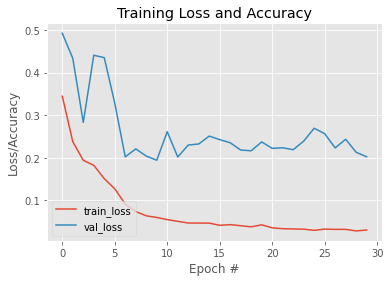

In [86]:
model = train_siamese_model(EPOCHS, train_ds, val_ds)

In [98]:
def VisualizeResults(images, refImages, labels, classnames, model):
    pairs = []
    idxA = [np.where(labels == i)[0] for i  in classnames]
    for k in classnames:
      idxB = np.random.choice(idxA[list(classnames).index(k)])
      currentImage = images[idxB]
      pairs.append((currentImage, refImages))
    
    # loop over all image pairs
    for (i, (pathA, paths)) in enumerate(pairs):
        # load both the images and convert them to grayscale
        imageA = cv2.imread(str(pathA))
        imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)

        # initialize the figure
        fig = plt.figure("Pair #{}".format(i + 1), figsize=(10, 2))
        ax = fig.add_subplot(1, 6, 1)
        plt.imshow(imageA, cmap=plt.cm.gray)
        ax.set_title(f"{Path(pathA).parent.name}")
        imageA = np.expand_dims(imageA, axis=0)
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        for j, path in enumerate(paths):
            imageB = cv2.imread(str(path))
            imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
            # create a copy of both the images for visualization purpose
            origB = imageB.copy()
            # add a batch dimension to both images
            imageB = np.expand_dims(imageB, axis=0)
            # use our siamese model to make predictions on the image pair,
            # indicating whether or not the images belong to the same class
            preds = model.predict([imageA, imageB])
            proba = preds[0][0]

            # show the second image
            ax = fig.add_subplot(1, 6, j+2)
            plt.imshow(origB, cmap=plt.cm.gray)
            ax.set_title(f"{Path(path).parent.name}")
            ax.set_xlabel("{:.2f}".format(proba))
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

        # show the plot
        plt.show()

In [99]:
classes = np.unique(coffee_classes)
idx = [np.where(coffee_classes == i)[0] for i  in classes]
pairs = []
refImages = []

for c in classes:
    idxB = np.random.choice(idx[list(classes).index(c)])
    currentImage = coffee_images[idxB]
    print(f"Current: {currentImage}")
    refImages.append(currentImage)

# idxA = [np.where(coffee_classes == i)[0] for i  in classes]
# for k in classes:
#   idxB = np.random.choice(idxA[list(classes).index(k)])
#   currentImage = coffee_images[idxB]
#   pairs.append((currentImage, refImages))

# print(pairs)

Current: /home/ubuntu/Downloads/train_opencv_resized/Cescospora/IMG_20221126_111700-576x768_jpg.rf.33e9da582304b857f78bd1a00165ced6.jpg
Current: /home/ubuntu/Downloads/train_opencv_resized/Healthy/cld-kaggle-train-healthy (277).jpg
Current: /home/ubuntu/Downloads/train_opencv_resized/Miner/1109.jpg
Current: /home/ubuntu/Downloads/train_opencv_resized/Phoma/cld-kaggle-train-phoma (363).jpg
Current: /home/ubuntu/Downloads/train_opencv_resized/Rust/C5P29H2.jpg


1/1 [==============================] - 0s 21ms/step


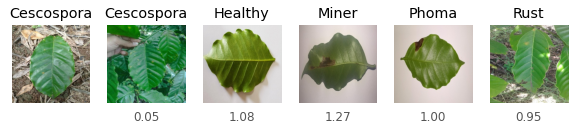

1/1 [==============================] - 0s 22ms/step


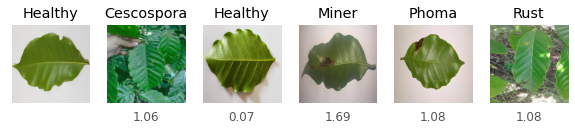

1/1 [==============================] - 0s 20ms/step


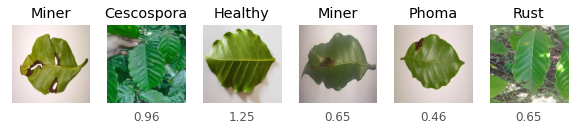

1/1 [==============================] - 0s 20ms/step


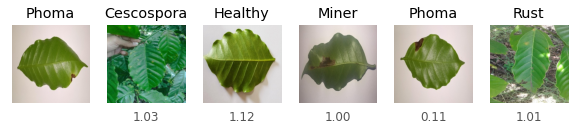

1/1 [==============================] - 0s 20ms/step


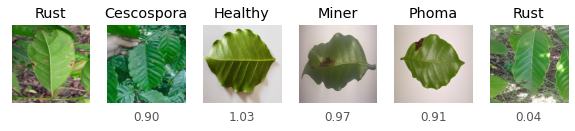

In [101]:
VisualizeResults(coffee_images, refImages, coffee_classes, classes, model)

1/1 [==============================] - 0s 21ms/step


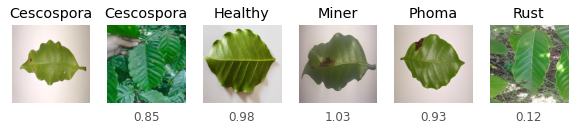

1/1 [==============================] - 0s 23ms/step


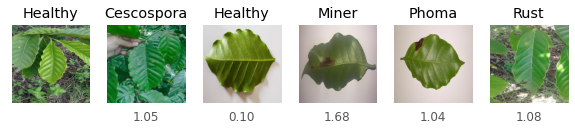

1/1 [==============================] - 0s 21ms/step


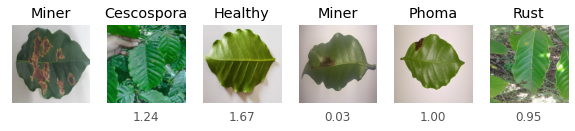

1/1 [==============================] - 0s 21ms/step


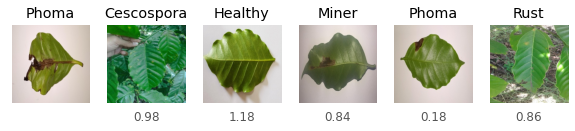

1/1 [==============================] - 0s 21ms/step


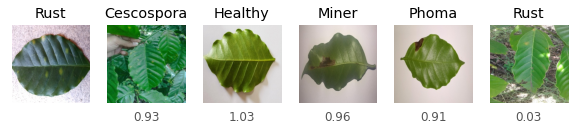

In [103]:
VisualizeResults(val_images, refImages, val_class, classes, model)

In [ ]:
import tensorflow as tf
with tf.keras.saving.custom_object_scope({"contrastive_loss": contrastive_loss}):
    reconstructed_model = tf.keras.saving.load_model('/content/drive/MyDrive/Siamese_First_try_epoch10')

In [107]:
def calculateDistances(inputImage, refImages, model):
  # load both the images and convert them to grayscale
  predictions = []
  imageA = cv2.imread(inputImage)
  imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
  imageA = np.expand_dims(imageA, axis=0)

  for j, path in enumerate(refImages):
    imageB = cv2.imread(str(path))
    imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
    imageB = np.expand_dims(imageB, axis=0)
    preds = model.predict([imageA, imageB])
    predictions.append(preds[0][0])

  return predictions

In [111]:
def buildPredictionsDataFrame(inputImages, refImages, model):
  img_id = []
  true_label = []
  predicted_label = []
  min_predicted_distance = []
  predicted_distances = []
  ## for each image build pair- predict and save result in dataframe
  for image in inputImages:
    predictions = calculateDistances(image, refImages, model)
    img_id.append(Path(image).name)
    true_label.append(Path(image).parent.name)
    predicted_class = np.where(predictions == np.min(predictions))
    predicted_label.append(classes[predicted_class[0].flatten()[0]])
    min_predicted_distance.append(np.min(predictions))
    predicted_distances.append(predictions)
  df = pd.DataFrame(data=
      {
          'Input': img_id,
          'Actual_Label': true_label,
          'Pred_Label': predicted_label,
          'Min_distance': min_predicted_distance,
          'All_distances': predicted_distances
      }
  )

  return df


In [112]:
#traindf = buildPredictionsDataFrame(coffee_images, refImages, reconstructed_model)
#traindf.head()

In [ ]:
valdf = buildPredictionsDataFrame(val_images, refImages, model)
valdf.head()

1/1 [==============================] - 0s 20ms/step


In [ ]:
train_df.to_csv('/content/drive/MyDrive/trainpred.csv')

In [ ]:
# loop over all image pairs
for (i, (pathA, paths)) in enumerate(pairs):
	# load both the images and convert them to grayscale
	imageA = cv2.imread(str(pathA))
	imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)

	# initialize the figure
	fig = plt.figure("Pair #{}".format(i + 1), figsize=(10, 2))
	ax = fig.add_subplot(1, 6, 1)
	plt.imshow(imageA, cmap=plt.cm.gray)
	ax.set_title(f"{Path(pathA).parent.name}")
	imageA = np.expand_dims(imageA, axis=0)
	plt.gca().set_yticklabels([])
	plt.gca().set_xticklabels([])
	plt.gca().set_xticks([])
	plt.gca().set_yticks([])

	for j, path in enumerate(paths):
		imageB = cv2.imread(str(path))
		imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
		# create a copy of both the images for visualization purpose
		origB = imageB.copy()
		# add a batch dimension to both images
		imageB = np.expand_dims(imageB, axis=0)
		# use our siamese model to make predictions on the image pair,
		# indicating whether or not the images belong to the same class
		preds = reconstructed_model.predict([imageA, imageB])
		proba = preds[0][0]

		# show the second image
		ax = fig.add_subplot(1, 6, j+2)
		plt.imshow(origB, cmap=plt.cm.gray)
		ax.set_title(f"{Path(path).parent.name}")
		ax.set_xlabel("{:.2f}".format(proba))
		plt.gca().set_yticklabels([])
		plt.gca().set_xticklabels([])
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])

	# show the plot
	plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Siamese_First_try_epoch10")

## Error Analysis

In [ ]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [ ]:
WEIGHT_DIR = Path('/content/drive/MyDrive/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
EPOCHS=10
# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
weights = {0:(4444/(4*664)), 1:(4444/(4*180)), 2:(4444/(4*908)), 3:(4444/(4*743)), 4:(4444/(4*1504))}
history = model_1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      #steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

In [ ]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Error Analysis

In [ ]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [ ]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [ ]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [ ]:
train_true, train_pred = generateMatrix(train_ds)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

In [ ]:
val_true, val_pred = generateMatrix(val_ds)

In [ ]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

In [ ]:
plt.subplots(4, 4, figsize=(10, 10))
for image, label in val_ds.take(1):
    pred_kps = model_1.predict(image)
    for i, k in enumerate(np.random.randint(batch_size, size=16)):
      plt.subplot(4, 4, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image[i].numpy().astype("uint8"))
      plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[i]]}/ GT: {CLASSNAMES[label[i]]}")
    #plt.xlabel(f"GT:{input_class[k]}")
plt.show()

## Evaluate from saved model

In [ ]:
checkPathExists(Path(testDirectory).parent/'models/MobileNetV2_weights')

In [ ]:
from tensorflow.train import latest_checkpoint
latest = latest_checkpoint(Path(testDirectory).parent/'models/MobileNetV2_weights')
latest

In [ ]:
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization
# Optimizer
from tensorflow.keras.optimizers import Adam

backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
outputs = Dense(5, activation='softmax')(x)

#Model
model_2 = Model(inputs, outputs, name=MODEL_NAME)

# Compile
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.

model_2.load_weights(latest)


In [ ]:
tf.strings.as_string(b'file_path')

In [ ]:
Eval_VAL_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)
def process_path_mod(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  #img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB )
  img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
  parts = tf.strings.split(file_path, os.path.sep)
  return img, label, parts[-1]
Eval_VAL_ds = Eval_VAL_ds.map(process_path_mod, num_parallel_calls=tf.data.AUTOTUNE)
Eval_VAL_ds = configure_for_performance(Eval_VAL_ds)


In [ ]:
plt.subplots(8, 2, figsize=(20, 20))
i=1
for image, label, file_path in Eval_VAL_ds.take(1):
    pred_kps = model_2.predict(image.numpy().reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3))
    for i, k in enumerate(np.random.randint(batch_size, size=16)):
      plt.subplot(8, 2, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image[k].numpy().astype("uint8"))
      plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[k]]} \n GT: {CLASSNAMES[label[k]]} \n {file_path[k]}")
      #plt.xlabel(f"GT:{input_class[k]}")
      i = i+1
plt.tight_layout()
plt.show()

In [ ]:
im = cv2.imread(str(SINGLE_LEAVES_DATA_DIR_TEST/'Healthy/C5P40H1.jpg'))
im1 = cv2.resize(im, [256, 256])
img = tf.io.read_file(str(SINGLE_LEAVES_DATA_DIR_TEST/'Healthy/C5P40H1.jpg'))
imi = tf.io.decode_jpeg(img, channels=3)
im2 = tf.image.resize(im, [256, 256])


In [ ]:
im_1 = np.reshape(im1, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])

In [ ]:
im_1.shape

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [ ]:
pred_kps = model_2.predict(im_1)

In [ ]:
model_2.get_layer("mobilenetv2_1.00_224").output, model_2.output

In [ ]:
gradcamimage = make_gradcam_heatmap(im_1, model_2, "mobilenetv2_1.00_224")

In [ ]:
CLASSNAMES[np.argmax(pred_kps)]

In [ ]:
plt.subplots(1, 3)
plt.subplot(1, 3, 1)
VisualizeSampleImages(im, True)
plt.subplot(1, 3, 2)
VisualizeSampleImages(im1, True)
plt.subplot(1, 3, 3)
VisualizeSampleImages(im2.numpy().astype('uint8'))